# 04 - Media Sentiment Deep Dive
## Grammy Song of the Year 2026 Prediction

This notebook analyzes media coverage and sentiment:
- Coverage volume trends
- Sentiment analysis
- Grammy buzz detection

In [11]:
import sys
sys.path.insert(0, '../src')

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime, timedelta

from data_sources import SONG_UNIVERSE

print("Imports successful!")

Imports successful!


## 1. Load Data

In [12]:
# Load all data
data_dir = Path('../data')

with open(data_dir / 'all_data.json', 'r') as f:
    all_data = json.load(f)

with open(data_dir / 'media_sentiment.json', 'r') as f:
    media_data = json.load(f)

print(f"Loaded media data for {len(media_data)} songs")

Loaded media data for 8 songs


## 2. Media Coverage Overview

In [13]:
# Media coverage summary
media_summary = []
for song_name, song in all_data.items():
    mc = song['media']
    media_summary.append({
        'Song': song_name,
        'Article Count': mc['article_count'],
        'Avg Sentiment': round(mc['avg_sentiment'], 3),
        'Sentiment Std': round(mc['sentiment_std'], 3),
        'Sentiment Trend': round(mc['sentiment_trend'], 3),
        'Positive Ratio': round(mc['positive_article_ratio'], 2),
        'Grammy Mentions': mc['grammy_mention_count']
    })

media_df = pd.DataFrame(media_summary)
media_df = media_df.sort_values('Article Count', ascending=False)
print("Media Coverage Summary:")
display(media_df)

Media Coverage Summary:


,Song,Article Count,Avg Sentiment,Sentiment Std,Sentiment Trend,Positive Ratio,Grammy Mentions
1,APT.,87,0.424,0.182,0.153,0.71,37
4,luther,83,0.626,0.190,0.071,0.81,35
3,Abracadabra,77,0.670,0.158,0.087,0.84,33
7,DtMF,74,0.675,0.294,-0.076,0.84,21
2,WILDFLOWER,69,0.323,0.129,0.023,0.66,34
5,Manchild,60,0.514,0.249,0.122,0.76,7
6,Anxiety,28,0.287,0.281,0.134,0.64,17
0,Golden,9,0.377,0.230,0.106,0.69,3


## 3. Coverage Volume Analysis

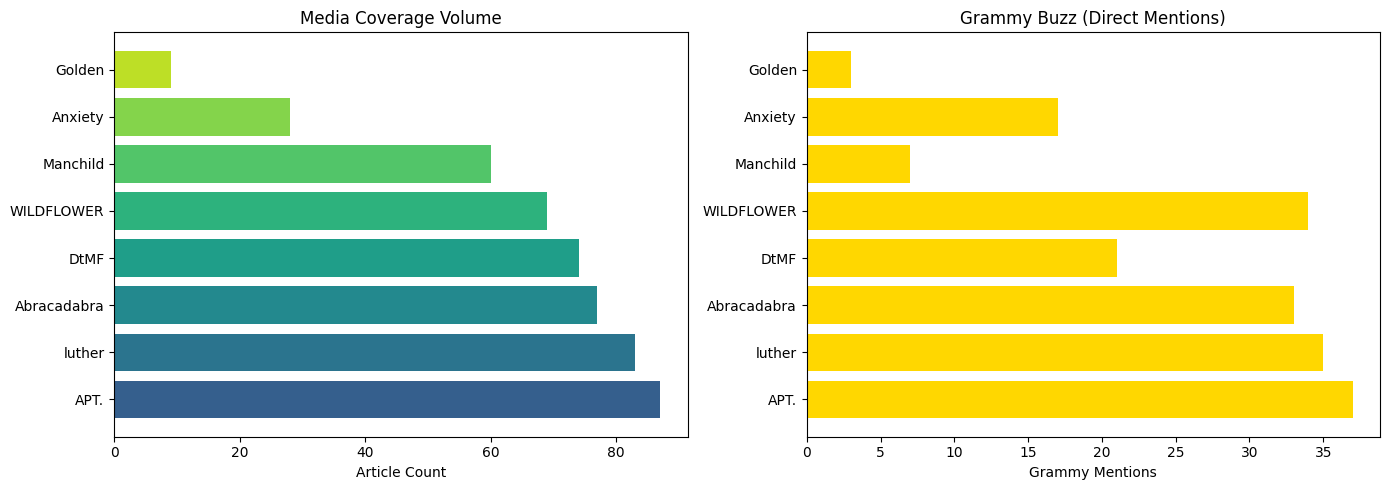

In [14]:
# Visualize coverage volume
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Article count
ax = axes[0]
songs = media_df['Song'].tolist()
articles = media_df['Article Count'].tolist()
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(songs)))
ax.barh(songs, articles, color=colors)
ax.set_xlabel('Article Count')
ax.set_title('Media Coverage Volume')

# Grammy mentions
ax = axes[1]
grammy_mentions = media_df['Grammy Mentions'].tolist()
ax.barh(songs, grammy_mentions, color='gold')
ax.set_xlabel('Grammy Mentions')
ax.set_title('Grammy Buzz (Direct Mentions)')

plt.tight_layout()
plt.savefig('../data/media_coverage.png', dpi=150)
plt.show()

## 4. Sentiment Analysis

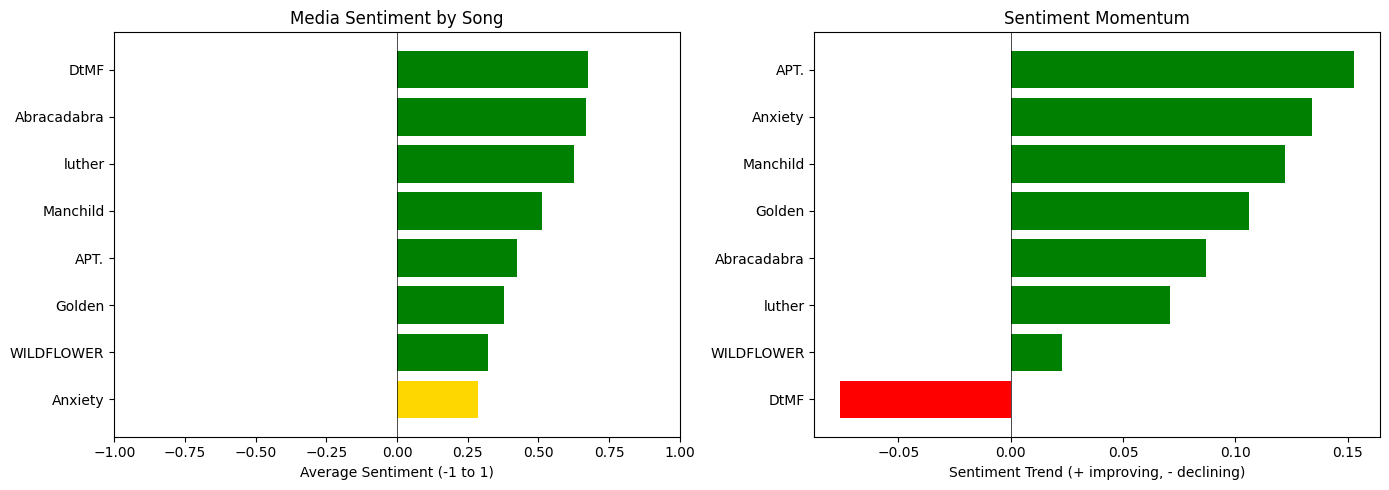

In [15]:
# Sentiment visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Average sentiment (sorted)
ax = axes[0]
sentiment_df = media_df.sort_values('Avg Sentiment', ascending=True)
songs = sentiment_df['Song'].tolist()
sentiments = sentiment_df['Avg Sentiment'].tolist()
colors = ['green' if s > 0.3 else 'gold' if s > 0 else 'red' for s in sentiments]
ax.barh(songs, sentiments, color=colors)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Average Sentiment (-1 to 1)')
ax.set_title('Media Sentiment by Song')
ax.set_xlim(-1, 1)

# Sentiment trend
ax = axes[1]
trend_df = media_df.sort_values('Sentiment Trend', ascending=True)
songs = trend_df['Song'].tolist()
trends = trend_df['Sentiment Trend'].tolist()
colors = ['green' if t > 0 else 'red' for t in trends]
ax.barh(songs, trends, color=colors)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Sentiment Trend (+ improving, - declining)')
ax.set_title('Sentiment Momentum')

plt.tight_layout()
plt.savefig('../data/sentiment_analysis.png', dpi=150)
plt.show()

## 5. Publication Coverage

In [16]:
# Publications covering each song
print("Key Publications by Song:")
print("="*60)

for song_name, song in all_data.items():
    mc = song['media']
    print(f"\n{song_name}:")
    print(f"  Total Articles: {mc['article_count']}")
    print(f"  Publications: {', '.join(mc['notable_publications'])}")

Key Publications by Song:

Golden:
  Total Articles: 9
  Publications: Stereogum, Entertainment Weekly

APT.:
  Total Articles: 87
  Publications: Entertainment Weekly, Pitchfork, Billboard, Stereogum, Variety, Consequence, Rolling Stone, The Guardian

WILDFLOWER:
  Total Articles: 69
  Publications: Pitchfork, Entertainment Weekly, The Guardian, Consequence

Abracadabra:
  Total Articles: 77
  Publications: Pitchfork, Billboard, NME, Variety, New York Times, Rolling Stone, Entertainment Weekly

luther:
  Total Articles: 83
  Publications: Pitchfork, Stereogum

Manchild:
  Total Articles: 60
  Publications: The Guardian, Variety

Anxiety:
  Total Articles: 28
  Publications: Entertainment Weekly, Stereogum, Consequence

DtMF:
  Total Articles: 74
  Publications: New York Times, Entertainment Weekly


In [17]:
# Count publication appearances
from collections import Counter

all_publications = []
for song_name, song in all_data.items():
    all_publications.extend(song['media']['notable_publications'])

pub_counts = Counter(all_publications)

print("\nMost Active Publications:")
for pub, count in pub_counts.most_common(10):
    print(f"  {pub}: covering {count} songs")


Most Active Publications:
  Entertainment Weekly: covering 6 songs
  Stereogum: covering 4 songs
  Pitchfork: covering 4 songs
  Variety: covering 3 songs
  Consequence: covering 3 songs
  The Guardian: covering 3 songs
  Billboard: covering 2 songs
  Rolling Stone: covering 2 songs
  New York Times: covering 2 songs
  NME: covering 1 songs


## 6. Media Momentum Score

In [18]:
# Compute composite media momentum score
media_momentum = []

for song_name, song in all_data.items():
    mc = song['media']
    
    # Normalize components
    coverage_norm = min(mc['article_count'] / 100, 1.0)  # Cap at 100
    sentiment_norm = (mc['avg_sentiment'] + 1) / 2  # Map [-1,1] to [0,1]
    trend_norm = (mc['sentiment_trend'] + 0.5) / 1.0  # Map [-0.5,0.5] to [0,1]
    trend_norm = max(0, min(1, trend_norm))
    
    # Weighted momentum score
    momentum = 0.4 * coverage_norm + 0.35 * sentiment_norm + 0.25 * trend_norm
    
    media_momentum.append({
        'Song': song_name,
        'Coverage Score': round(coverage_norm, 3),
        'Sentiment Score': round(sentiment_norm, 3),
        'Trend Score': round(trend_norm, 3),
        'Media Momentum': round(momentum, 3)
    })

momentum_df = pd.DataFrame(media_momentum)
momentum_df = momentum_df.sort_values('Media Momentum', ascending=False)
print("Media Momentum Rankings:")
display(momentum_df)

Media Momentum Rankings:


,Song,Coverage Score,Sentiment Score,Trend Score,Media Momentum
1,APT.,0.87,0.712,0.653,0.760
4,luther,0.83,0.813,0.571,0.759
3,Abracadabra,0.77,0.835,0.587,0.747
7,DtMF,0.74,0.838,0.424,0.695
5,Manchild,0.60,0.757,0.622,0.661
2,WILDFLOWER,0.69,0.661,0.523,0.638
6,Anxiety,0.28,0.643,0.634,0.496
0,Golden,0.09,0.689,0.606,0.429


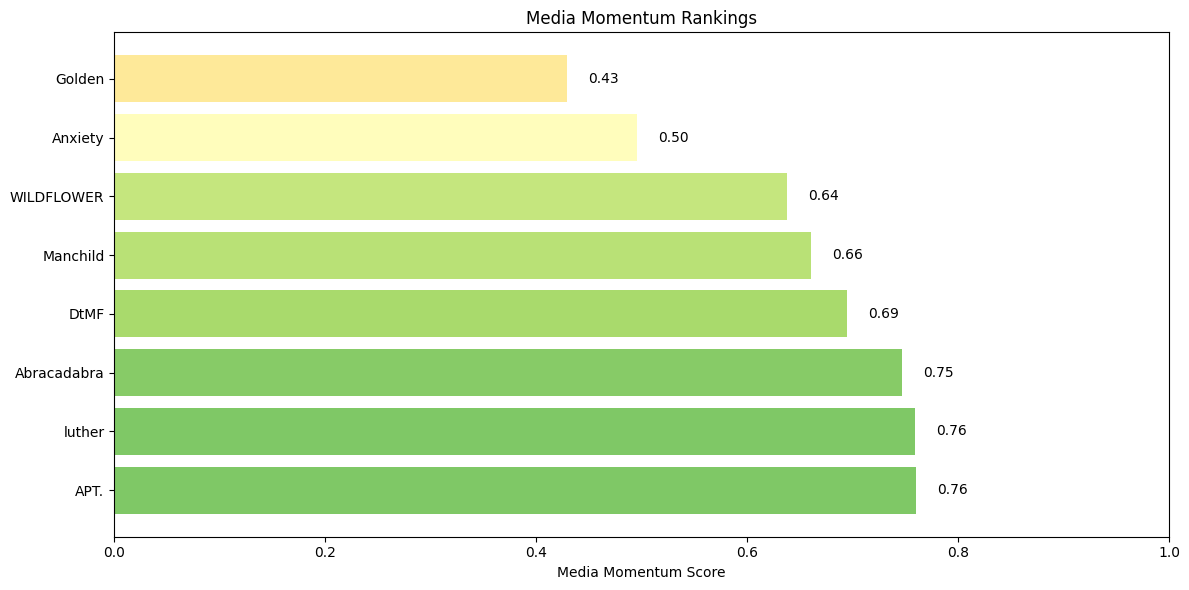

In [19]:
# Visualize media momentum
fig, ax = plt.subplots(figsize=(12, 6))

songs = momentum_df['Song'].tolist()
momentum = momentum_df['Media Momentum'].tolist()
colors = plt.cm.RdYlGn(np.array(momentum))

bars = ax.barh(songs, momentum, color=colors)
ax.set_xlabel('Media Momentum Score')
ax.set_title('Media Momentum Rankings')
ax.set_xlim(0, 1)

for bar, score in zip(bars, momentum):
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
            f'{score:.2f}', va='center')

plt.tight_layout()
plt.savefig('../data/media_momentum.png', dpi=150)
plt.show()

## 7. Save Results

In [20]:
# Save media momentum scores
momentum_dict = momentum_df.set_index('Song').to_dict('index')
with open('../data/media_momentum.json', 'w') as f:
    json.dump(momentum_dict, f, indent=2)

momentum_df.to_csv('../data/media_momentum.csv', index=False)

print("Saved:")
print("  • media_momentum.json")
print("  • media_momentum.csv")

Saved:
  • media_momentum.json
  • media_momentum.csv


## Summary

Key findings:
1. **Coverage Volume** - Total articles and mentions
2. **Sentiment** - Overall tone of coverage
3. **Momentum** - Trend direction (improving vs declining)
4. **Grammy Buzz** - Direct award mentions

**Next:** Notebook 05 - Final Scoring & Predictions